In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets.qm9 import QM9
import torch_geometric.datasets.qm9 as qm9
from torch_geometric.data import DataLoader
import torch_geometric.nn as tgnn
from torch_geometric.data import Data
from torch_scatter import scatter
import torch_geometric
import tqdm
import numpy as np
import wandb
import random
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from matplotlib import pyplot as plt
import networkx as nx

manualSeed = 43
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  43


In [2]:
useHs = False

In [3]:
df = pd.read_csv('../../datasets/ChEMBL/small_molecules.csv', delimiter=';')

/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df['Smiles']

0          CCC(=O)O[C@H]1[C@H](C)O[C@@H](O[C@@H]2[C@@H](C...
1                  COc1ccc(Cl)cc1-c1cc(Nc2ccc(Cl)cc2)nc(N)n1
2          COc1ccc(/C=C/C2=NN(CCCN)C(=O)N(Cc3ccc4ccccc4c3...
3                    Cc1ccc(CCN2CC(C(=O)NCc3cccnc3)CC2=O)cc1
4                                               CCCCC(=O)O.N
                                 ...                        
1920134    COc1ccnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[n-]2)c...
1920135      CN1c2c(oc(=O)n(-c3ccccn3)c2=O)-c2ccccc2S1(=O)=O
1920136                                                  NaN
1920137                                                  NaN
1920138    COc1cc([C@@H]2c3cc4c(cc3[C@H](O)[C@H]3COC(=O)[...
Name: Smiles, Length: 1920139, dtype: object

In [5]:
df.dropna(subset = ["Smiles"], inplace=True)

In [6]:
df['Smiles']

0          CCC(=O)O[C@H]1[C@H](C)O[C@@H](O[C@@H]2[C@@H](C...
1                  COc1ccc(Cl)cc1-c1cc(Nc2ccc(Cl)cc2)nc(N)n1
2          COc1ccc(/C=C/C2=NN(CCCN)C(=O)N(Cc3ccc4ccccc4c3...
3                    Cc1ccc(CCN2CC(C(=O)NCc3cccnc3)CC2=O)cc1
4                                               CCCCC(=O)O.N
                                 ...                        
1920132    Oc1ccc2c(c1)[C@@]13CCCC[C@@]1(O)[C@@H](C2)N(CC...
1920133                       Oc1ccc(/C=C/c2cc(O)cc(O)c2)cc1
1920134    COc1ccnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[n-]2)c...
1920135      CN1c2c(oc(=O)n(-c3ccccn3)c2=O)-c2ccccc2S1(=O)=O
1920138    COc1cc([C@@H]2c3cc4c(cc3[C@H](O)[C@H]3COC(=O)[...
Name: Smiles, Length: 1914648, dtype: object

In [7]:
df.keys()

Index(['ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP', 'PSA', 'HBA',
       'HBD', '#RO5 Violations', '#Rotatable Bonds', 'Passes Ro3',
       'QED Weighted', 'CX ApKa', 'CX BpKa', 'CX LogP', 'CX LogD',
       'Aromatic Rings', 'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       'HBA Lipinski', 'HBD Lipinski', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Molecular Species',
       'Molecular Formula', 'Smiles'],
      dtype='object')

In [8]:
smiles = df['Smiles'][111]
mol = Chem.MolFromSmiles(smiles)

In [9]:
smiles = df['Smiles'][df['ChEMBL ID'] == 'CHEMBL4099974']

In [10]:
smiles

2    COc1ccc(/C=C/C2=NN(CCCN)C(=O)N(Cc3ccc4ccccc4c3...
Name: Smiles, dtype: object

In [11]:
mol = Chem.MolFromSmiles(smiles[2]) 

In [12]:
df['Smiles'].to_csv('../../datasets/ChEMBL/smiles.csv', index=False)

In [13]:
supplier = Chem.rdmolfiles.SmilesMolSupplier('../../datasets/ChEMBL/smiles.csv', delimiter='', sanitize=False)

# Determine all atom and bond types that occur

In [14]:
atom_types = {}
bond_types = {}
n_atoms_list = []
n_bonds_list = []

In [15]:
curr_atom_type = 0
curr_bond_type = 0
max_atoms = 0
max_bonds = 0
for mol in tqdm.tqdm(supplier):
    if useHs:
        mol = Chem.rdmolops.AddHs(mol)
    if mol is None:
        print(smiles, 'yields None')
        continue
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol not in atom_types:
            atom_types[symbol] = curr_atom_type
            curr_atom_type += 1
    for bond in mol.GetBonds():
        btype = bond.GetBondType()
        if btype not in bond_types:
            bond_types[btype] = curr_bond_type 
            curr_bond_type += 1
    n_atoms = len(mol.GetAtoms())
    n_bonds = len(mol.GetBonds())
    if max_atoms < n_atoms:
        max_atoms = n_atoms
    if max_bonds < n_bonds:
        max_bonds = n_bonds
    n_atoms_list += [n_atoms]
    n_bonds_list += [n_bonds]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1914648/1914648 [06:37<00:00, 4816.25it/s]


In [16]:
bond_types

{rdkit.Chem.rdchem.BondType.SINGLE: 0,
 rdkit.Chem.rdchem.BondType.DOUBLE: 1,
 rdkit.Chem.rdchem.BondType.AROMATIC: 2,
 rdkit.Chem.rdchem.BondType.TRIPLE: 3}

(array([3.14000e+02, 1.55100e+03, 6.89100e+03, 2.40450e+04, 6.16890e+04,
        1.32353e+05, 2.26059e+05, 4.00176e+05, 2.85181e+05, 2.50702e+05,
        1.83503e+05, 1.16324e+05, 7.09060e+04, 4.48230e+04, 2.70580e+04,
        2.27480e+04, 1.16540e+04, 7.90100e+03, 7.22600e+03, 5.79700e+03,
        4.63800e+03, 3.47700e+03, 2.75300e+03, 2.55600e+03, 1.43000e+03,
        1.32700e+03, 1.22600e+03, 1.06700e+03, 8.35000e+02, 7.44000e+02,
        6.62000e+02, 7.07000e+02, 4.87000e+02, 5.34000e+02, 4.03000e+02,
        4.33000e+02, 4.19000e+02, 3.57000e+02, 3.40000e+02, 2.11000e+02,
        1.94000e+02, 1.54000e+02, 1.54000e+02, 1.77000e+02, 1.61000e+02,
        1.27000e+02, 1.23000e+02, 1.17000e+02, 8.30000e+01, 5.60000e+01,
        5.00000e+01, 4.90000e+01, 4.60000e+01, 5.10000e+01, 6.00000e+01,
        5.70000e+01, 3.20000e+01, 6.80000e+01, 6.10000e+01, 3.50000e+01,
        3.10000e+01, 2.90000e+01, 2.40000e+01, 2.50000e+01, 2.70000e+01,
        2.60000e+01, 3.10000e+01, 3.00000e+01, 1.30

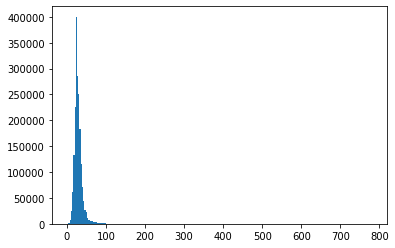

In [17]:
plt.hist(n_atoms_list, bins='rice')

(array([3.63000e+02, 1.32000e+03, 4.75400e+03, 1.44810e+04, 5.35300e+04,
        9.15320e+04, 1.59889e+05, 2.28841e+05, 2.71099e+05, 3.39269e+05,
        2.21537e+05, 1.70071e+05, 1.15377e+05, 9.23850e+04, 4.06630e+04,
        2.63040e+04, 1.74010e+04, 1.23030e+04, 1.18560e+04, 6.58500e+03,
        5.50800e+03, 4.82800e+03, 3.94700e+03, 3.70200e+03, 1.89300e+03,
        1.70000e+03, 1.46600e+03, 1.51400e+03, 1.02400e+03, 8.38000e+02,
        6.79000e+02, 6.92000e+02, 7.91000e+02, 5.27000e+02, 4.34000e+02,
        4.51000e+02, 6.13000e+02, 3.39000e+02, 3.27000e+02, 3.18000e+02,
        2.40000e+02, 2.50000e+02, 1.79000e+02, 1.89000e+02, 1.57000e+02,
        1.23000e+02, 1.84000e+02, 1.15000e+02, 1.18000e+02, 6.40000e+01,
        7.00000e+01, 4.90000e+01, 4.50000e+01, 4.40000e+01, 6.30000e+01,
        7.50000e+01, 3.60000e+01, 3.00000e+01, 5.20000e+01, 8.70000e+01,
        4.70000e+01, 2.80000e+01, 2.20000e+01, 1.70000e+01, 3.80000e+01,
        3.60000e+01, 2.40000e+01, 3.10000e+01, 1.90

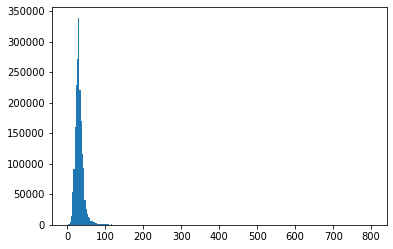

In [18]:
plt.hist(n_bonds_list, bins='rice')

In [19]:
atom_types

{'C': 0,
 'O': 1,
 'N': 2,
 'Cl': 3,
 'S': 4,
 'F': 5,
 'P': 6,
 'Se': 7,
 'Br': 8,
 'I': 9,
 'Na': 10,
 'B': 11,
 'K': 12,
 'Li': 13,
 'H': 14,
 'Si': 15,
 'Ca': 16,
 'Rb': 17,
 'Te': 18,
 'Zn': 19,
 'Mg': 20,
 'As': 21,
 'Al': 22,
 'Ba': 23,
 'Be': 24,
 'Sr': 25,
 'Ag': 26,
 'Bi': 27,
 'Ra': 28,
 'Kr': 29,
 'Cs': 30,
 'Xe': 31,
 'He': 32}

In [20]:
bond_types

{rdkit.Chem.rdchem.BondType.SINGLE: 0,
 rdkit.Chem.rdchem.BondType.DOUBLE: 1,
 rdkit.Chem.rdchem.BondType.AROMATIC: 2,
 rdkit.Chem.rdchem.BondType.TRIPLE: 3}

In [21]:
supplier = Chem.rdmolfiles.SmilesMolSupplier('../../datasets/ChEMBL/smiles.csv', delimiter='', sanitize=False)

In [22]:
types = atom_types
bonds = bond_types
data_list = []

for i,(mol_id, mol) in tqdm.tqdm(enumerate(zip(df['ChEMBL ID'], supplier))):
    if mol is None:
        print(smiles, 'yields None')
        continue
    if useHs:
        mol = Chem.rdmolops.AddHs(mol)        
    N = mol.GetNumAtoms()
    
    type_idx = []
    atomic_number = []
    aromatic = []
    sp = []
    sp2 = []
    sp3 = []
    num_hs = []
    for atom in mol.GetAtoms():
        type_idx.append(types[atom.GetSymbol()])
        atomic_number.append(atom.GetAtomicNum())
        aromatic.append(1 if atom.GetIsAromatic() else 0)
        hybridization = atom.GetHybridization()
        sp.append(1 if hybridization == HybridizationType.SP else 0)
        sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
        sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
    
    z = torch.tensor(atomic_number, dtype=torch.long)

    type_idx = np.asarray(type_idx)
    atomic_number = np.asarray(atomic_number)
    aromatic = np.asarray(atomic_number)
    sp = np.asarray(sp)
    sp2 = np.asarray(sp2)
    sp3 = np.asarray(sp3)
    num_hs = np.asarray(num_hs)
    
    row, col, edge_type = [], [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
        edge_type += 2 * [bonds[bond.GetBondType()]]

    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    edge_attr = F.one_hot(edge_type,
                          num_classes=len(bonds)).to(torch.float)

    perm = (edge_index[0] * N + edge_index[1]).argsort()
    edge_index = edge_index[:, perm]
    edge_type = edge_type[perm]
    edge_attr = edge_attr[perm]

    row, col = edge_index
    hs = (z == 1).to(torch.float)
    num_hs = scatter(hs[row], col, dim_size=N).tolist()

    x1 = F.one_hot(torch.tensor(type_idx), num_classes=len(types))
    x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs],
                      dtype=torch.float).t().contiguous()
    x = torch.cat([x1.to(torch.float), x2], dim=-1)

    # only keep largest connected component
    edges_coo = edge_index.detach().cpu().numpy().T
    g = nx.Graph()
    g.add_nodes_from(np.arange(len(z)))
    g.add_edges_from(edges_coo.tolist())

    ccs = list(nx.connected_components(g))
    largest_cc = ccs[np.argmax([len(cc) for cc in ccs])]
    node_ids = np.asarray(list(largest_cc))

    x = x[node_ids]
    z = z[node_ids]
    edges_cc = []
    edge_feats = []
    old2new = {old:new for new, old in enumerate(node_ids)}
    for idx, (u, v) in enumerate(edges_coo):
        if u in node_ids and v in node_ids:
            edges_cc += [[old2new[u], old2new[v]]]
            edge_feats += [edge_attr[idx].numpy().tolist()]
    edge_index = torch.tensor(edges_cc, dtype=torch.long)
    edge_attr = torch.tensor(edge_feats, dtype=torch.float)

    name = mol_id

    data = Data(x=x, z=z, pos=None, edge_index=edge_index.T,
                edge_attr=edge_attr, y=None, name=name, idx=i)



    data_list.append(data)



1914648it [50:16, 634.81it/s]


In [23]:
n_splits = 64

[autoreload of schnetpack.atomistic.output_modules failed: Traceback (most recent call last):
  File "/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/chrisw/miniconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/chrisw/miniconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/chrisw/.cache/pypoetry/virtualenvs/gr

In [24]:
splits = np.array_split(np.arange(len(data_list)), n_splits)

In [25]:
for idx, split in tqdm.tqdm(enumerate(splits)):
    dlist = [data_list[idx] for idx in split]
    if useHs:
        torch.save(torch_geometric.data.InMemoryDataset.collate(dlist), '../../datasets/ChEMBL/preprocessedPlusHs_split%d.pt'%idx)
    else:
        torch.save(torch_geometric.data.InMemoryDataset.collate(dlist), '../../datasets/ChEMBL/preprocessedNoHs_split%d.pt'%idx)

64it [00:56,  1.14it/s]
